# Kaggle Competition 

In [2]:
import pandas as pd
import numpy as np
import joblib
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
val_df =  pd.read_parquet("data/validate_data.parquet")

In [4]:
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]

#select target values
target_cols = ["responder_6"]

# select the weight values
weight_cols = ["weight"]

In [6]:
X_val = val_df[feature_cols]
y_val = val_df[target_cols]
w_val = val_df[weight_cols]

In [14]:
class MyModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims, dropouts, lr, weight_decay):
        super().__init__()
        self.save_hyperparameters()
        layers = []
        in_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.BatchNorm1d(in_dim))
            if i > 0:
                layers.append(nn.SiLU())
            if i < len(dropouts):
                layers.append(nn.Dropout(dropouts[i]))
            layers.append(nn.Linear(in_dim, hidden_dim))
            # layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, 1))  # 输出层
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        self.lr = lr
        self.weight_decay = weight_decay
        self.validation_step_outputs = []
    
    def forward(self, x):
        return 5 * self.model(x).squeeze(-1)
    
    def training_step(self, batch):
        x, y, w = batch
        y_hat = self(x)
        y = y.view(-1)
        loss = F.mse_loss(y_hat, y, reduction='none') * w  #
        loss = loss.mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        return loss

    def validation_step(self, batch):
        x, y, w = batch
        y_hat = self(x)
        y = y.view(-1)
        loss = F.mse_loss(y_hat, y, reduction='none') * w
        loss = loss.mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.validation_step_outputs.append((y_hat, y, w))
        return loss

    # def on_validation_epoch_end(self):
    #     """Calculate validation WRMSE at the end of the epoch."""
    #     y = torch.cat([x[1] for x in self.validation_step_outputs]).cpu().numpy()
    #     if self.trainer.sanity_checking:
    #         prob = torch.cat([x[0] for x in self.validation_step_outputs]).cpu().numpy()
    #     else:
    #         prob = torch.cat([x[0] for x in self.validation_step_outputs]).cpu().numpy()
    #         weights = torch.cat([x[2] for x in self.validation_step_outputs]).cpu().numpy()
    #         # Ensure the shapes match by specifying the axis
    #         val_r_square = r2_val(y, prob, weights, axis=0)
    #         self.log("val_r_square", val_r_square, prog_bar=True, on_step=False, on_epoch=True)
    #     self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                                                               verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

    # def on_train_epoch_end(self):
    #     if self.trainer.sanity_checking:
    #         return
    #     epoch = self.trainer.current_epoch
    #     metrics = {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in self.trainer.logged_metrics.items()}
    #     formatted_metrics = {k: f"{v:.5f}" for k, v in metrics.items()}
    #     print(f"Epoch {epoch}: {formatted_metrics}")

    def save_model(self, path):
        """Save the model's state dictionary to the specified path."""
        torch.save(self.state_dict(), path)

In [15]:
i= 0 
# model  = MyModel.load_from_checkpoint(f"lightning_logs/version_{i+25}/checkpoints/models/nn__fold{i}.model.ckpt")
model  = MyModel.load_from_checkpoint(f"lightning_logs/version_{24}/checkpoints/models/nn.model.ckpt")
model= model.to("cuda")
model.eval()

MyModel(
  (model): Sequential(
    (0): BatchNorm1d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=88, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SiLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): Linear(in_features=256, out_features=1, bias=True)
    (11): Tanh()
  )
)

In [16]:
from sklearn.metrics import r2_score

In [17]:
with torch.no_grad():
  pred = model(torch.FloatTensor(X_val.values).to("cuda"))
pred_nn = pred.cpu().detach().numpy()
r2 =  r2_score(y_val, pred_nn, sample_weight= w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.007308


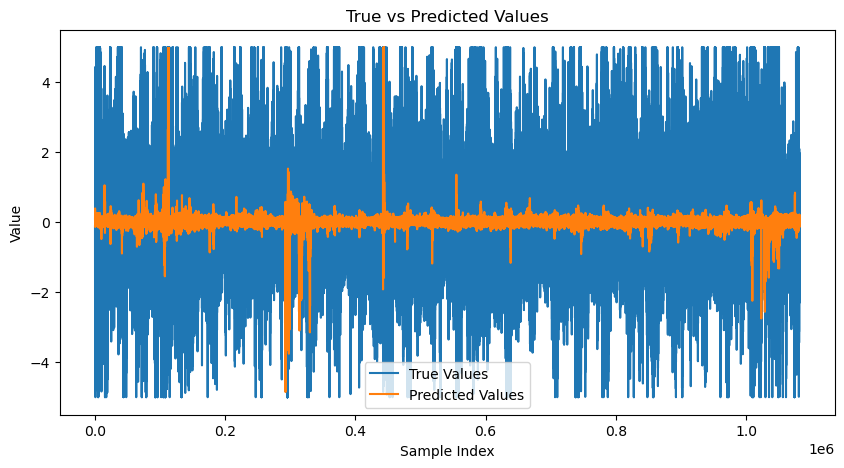

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(pred_nn, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [7]:
XGB_vote_model  =  joblib.load("model/XGBoost_voting_ensemble4.pkl")
ScaleX = joblib.load("model/XGBoost_scaleX.pkl")
ScaleY = joblib.load("model/XGBoost_scaleY.pkl")

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
XGB_vote_model

VotingRegressor(estimators=[('model1',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device='cuda',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_...
                                                                       gamma=0,
                                                                       grow_policy=None,
                                                                       importance_type=None,
                                                                       interaction_constraints=None,
                                                                       learning_rate=0.01,
                                                                       max_bin=None,
                                                                       max_cat_threshold=None,
                                                                       max_cat_to_onehot=None,
                                                                       max_delta_step=None,
                                                                       max_depth=7,
                                                                       max_leaves=None,
                                                                       min_child_weight=3,
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=1000,
                                                                       n_jobs=None,
                                                                       num_parallel_tree=None,
                                                                       random_state=42, ...))]))])

In [ ]:
X_val_scaled =  ScaleX.transform(X_val)
pred_XGB  =  ScaleY.inverse_transform(XGB_vote_model.predict(X_val_scaled).reshape(-1,1))
r2 =  r2_score(y_val, pred_XGB, sample_weight= w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.006943


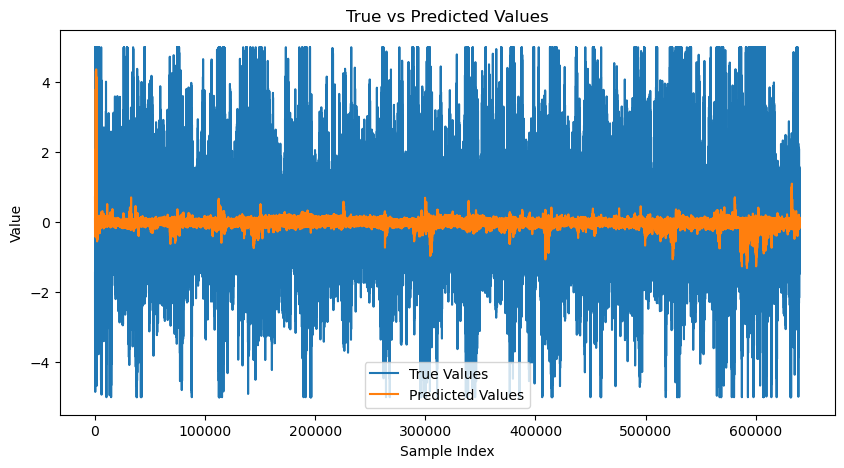

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(pred_XGB, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [74]:
preds = np.zeros((X_val.shape[0],))
preds  += pred_nn/2
preds  += pred_XGB.flatten()/2

r2 =  r2_score(y_val, preds, sample_weight= w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.007836


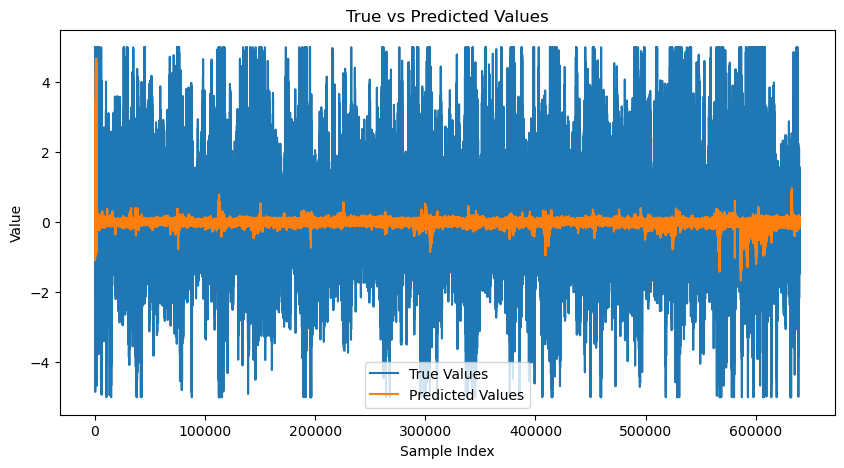

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(preds, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()